In [1]:
"""
DeepLabCut Toolbox
https://github.com/AlexEMG/DeepLabCut

A Mathis, alexander.mathis@bethgelab.org
M Mathis, mackenzie@post.harvard.edu

This script evaluates the scorer's labels and computes the accuracy.
"""

####################################################
# Dependencies
####################################################

import sys
import os
import pickle
sys.path.append(os.getcwd().split('Evaluation-Tools')[0])
from myconfig import Task, date, scorer, Shuffles, TrainingFraction, snapshotindex
import matplotlib
matplotlib.use('Agg')
import numpy as np
import pandas as pd

####################################################
# Auxiliary functions
####################################################


def pairwisedistances(DataCombined, scorer1, scorer2, bodyparts=None):
    if bodyparts is None:
        Pointwisesquareddistance = (
            DataCombined[scorer1] - DataCombined[scorer2])**2
        MSE = np.sqrt(
            Pointwisesquareddistance.xs('x', level=1, axis=1) +
            Pointwisesquareddistance.xs('y', level=1, axis=1))
        return MSE
    else:  # calculationg MSE only for specific bodyparts / given by list
        Pointwisesquareddistance = (DataCombined[scorer1][bodyparts] -
                                    DataCombined[scorer2][bodyparts])**2
        MSE = np.sqrt(
            Pointwisesquareddistance.xs('x', level=1, axis=1) +
            Pointwisesquareddistance.xs('y', level=1, axis=1))
        return MSE



In [2]:

fs = 15  # fontsize for plots
####################################################
# Loading dependencies
####################################################

# loading meta data / i.e. training & test files
basefolder = '../pose-tensorflow/models/'
datafolder = basefolder + "UnaugmentedDataSet_" + Task + date + '/'
Data = pd.read_hdf(
    datafolder + 'data-' + Task + '/CollectedData_' + scorer + '.h5',
    'df_with_missing')



In [3]:
####################################################
# Models vs. benchmark for varying training state
####################################################

# only specific parts can also be compared (not all!):
comparisonbodyparts = list(np.unique(Data.columns.get_level_values(1)))

for trainFraction in TrainingFraction:
    for shuffle in Shuffles:

        fns = [
            file for file in os.listdir('Results')
            if "forTask:" + str(Task) in file and "shuffle" + str(shuffle) in
            file and "_" + str(int(trainFraction * 100)) in file
        ]
        
        if fns:

            metadatafile = datafolder + "Documentation_" + "data-" + Task + "_" + str(
                int(trainFraction * 100)) + "shuffle" + str(shuffle) + ".pickle"
            with open(metadatafile, 'rb') as f:
                [
                    trainingdata_details, trainIndexes, testIndexes,
                    testFraction_data
                ] = pickle.load(f)

            #extract training iterations:
            TrainingIterations=[(int(fns[j].split("forTask")[0].split('_')[-1]),j) for j in range(len(fns))]
            TrainingIterations.sort(key=lambda tup: tup[0]) #sort according to increasing # training steps!
            print("Found the following training snapshots: ",TrainingIterations)
            print("You can choose among those for analyis of train/test performance.")

            if snapshotindex == -1:
                snapindices = [TrainingIterations[-1]] #[-1]
            elif snapshotindex == "all":
                snapindices = TrainingIterations
            elif snapshotindex<len(TrainingIterations):
                snapindices=[TrainingIterations[snapshotindex]]
            else:
                print("Invalid choice, only -1 (last), all (as string), or index corresponding to one of the listed training snapshots can be analyzed.")
                print("Others might not have been evaluated!")
                snapindices=[]

            for trainingiterations,index in snapindices:
                DataMachine = pd.read_hdf("Results/" + fns[index], 'df_with_missing')
                DataCombined = pd.concat([Data.T, DataMachine.T], axis=0).T
                scorer_machine = DataMachine.columns.get_level_values(0)[0]

                MSE = pairwisedistances(DataCombined, scorer, scorer_machine,
                                        comparisonbodyparts)

                testerror = np.nanmean(MSE.iloc[testIndexes].values.flatten())
                trainerror = np.nanmean(MSE.iloc[trainIndexes].values.flatten())

                #print("Results Mean for",trainingiterations, "training iterations:", int(100 * trainFraction), shuffle, "train error:",
                 #    round(trainerror,3), "test error:", round(testerror,3))

                testerror = np.nanmedian(MSE.iloc[testIndexes].values.flatten())
                trainerror = np.nanmedian(MSE.iloc[trainIndexes].values.flatten())

                print("Results Median for",trainingiterations, "iter:", int(100 * trainFraction), shuffle, "train error:",
                      round(trainerror,3), "test error:", round(testerror,3))



('Found the following training snapshots: ', [(50000, 0), (300000, 1), (350000, 2), (400000, 3), (450000, 4), (500000, 5)])
You can choose among those for analyis of train/test performance.
('Results Median for', 50000, 'iter:', 70, 1, 'train error:', 2.035, 'test error:', 6.443)
('Results Median for', 300000, 'iter:', 70, 1, 'train error:', 1.085, 'test error:', 6.5)
('Results Median for', 350000, 'iter:', 70, 1, 'train error:', 1.157, 'test error:', 7.527)
('Results Median for', 400000, 'iter:', 70, 1, 'train error:', 1.368, 'test error:', 7.029)
('Results Median for', 450000, 'iter:', 70, 1, 'train error:', 1.097, 'test error:', 7.139)
('Results Median for', 500000, 'iter:', 70, 1, 'train error:', 0.963, 'test error:', 6.958)


In [4]:
fns

['DeepCut_resnetresnet_50_70shuffle1_50000forTask:standing- MAY 03 NET.h5',
 'DeepCut_resnetresnet_50_70shuffle1_300000forTask:standing.h5',
 'DeepCut_resnetresnet_50_70shuffle1_350000forTask:standing.h5',
 'DeepCut_resnetresnet_50_70shuffle1_400000forTask:standing.h5',
 'DeepCut_resnetresnet_50_70shuffle1_450000forTask:standing.h5',
 'DeepCut_resnetresnet_50_70shuffle1_500000forTask:standing.h5']

## Visualization ------------------------------------------------------------------

In [5]:
MSE_worst_thr = 20

MSE_best_thr = 20#3

In [6]:
train_Err = MSE.iloc[trainIndexes]
print (np.max(train_Err))   #during train did not use pictures with ocluded parts!!!!
train_Err[train_Err.values.flatten()  > MSE_worst_thr].shape

bodyparts
knee    3.067393
dtype: float64


(0, 1)

In [7]:
test_Err = MSE.iloc[testIndexes]
print (np.max(test_Err))
test_Err[test_Err.values.flatten() < MSE_best_thr ]# > MSE_worst_thr].shape

bodyparts
knee    987.14493
dtype: float64


bodyparts,knee
video_04/frame0008.png,6.383249
video_07/frame0009.png,8.803453
video_12/frame0007.png,17.082679
video_06/frame0002.png,2.852667
video_15/frame0005.png,3.028617
video_05/frame0005.png,3.919024
video_14/frame0008.png,5.351802
video_08/frame0004.png,9.627157
video_04/frame0003.png,4.890490
video_15/frame0009.png,3.734523


In [8]:
test_Err.median()

bodyparts
knee    6.957628
dtype: float64

In [9]:
test_Err[test_Err.values.flatten()  > MSE_worst_thr] #< MSE_best_thr ] #

bodyparts,knee
video_02/frame0006.png,47.376908
video_17/frame0009.png,916.796501
video_09/frame0000.png,75.220774
video_12/frame0004.png,342.399673
video_00/frame0005.png,852.618711
video_09/frame0001.png,282.132357
single_images_00/frame03.png,400.493461
video_12/frame0009.png,390.597395
single_images_00/frame05.png,24.470650
single_images_01/frame09.png,192.175894


In [10]:
%matplotlib inline
from skimage import io
import matplotlib
#matplotlib.use('Agg')
import numpy as np
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,3]
from myconfig import Task, filename, bodyparts, Scorers
from myconfig import scorer as cfg_scorer

Labels = ['.', '+', '*']  # order of labels for different scorers

Colorscheme = ['r', 'g', 'y', 'b', 'm', 'r', 'g', 'y',
               'b']  # colors for those bodyparts.

In [11]:
k = 0

scale = 1  # for plotting
msize = 20   #size of labels

worst = test_Err[test_Err.values.flatten()   < MSE_best_thr ]#> MSE_worst_thr]# < MSE_best_thr ]#

In [12]:
 scorer, scorer_machine,

('camila', 'DeepCut_resnetresnet_50_70shuffle1_500000forTask:standing')

In [13]:
for k, sam in enumerate(worst.index.values):

    imagename = worst.index.values[k]

    imindex = np.where(
                np.array(DataCombined.index.values) == imagename)[0]

    image = io.imread('/is/ps2/calvarez2/DeepLabCut/pose-tensorflow/models/UnaugmentedDataSet_standingMay03/data-standing/' + imagename)



    plt.axis('off')

    bp = list(set(DataCombined.columns.get_level_values(1)))[0]

    print imagename +' ' + str(DataCombined[scorer_machine][bp]['likelihood'].values[imindex]) #+ '\n'

    h, w, nc = np.shape(image)
    plt.figure(
        frameon=False, figsize=(w * 1. / 100 * scale, h * 1. / 100 * scale))
    plt.subplots_adjust(
        left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    plt.imshow(image, 'bone')

    plt.plot(   DataCombined[scorer][bp]['x'].values[imindex],
                DataCombined[scorer][bp]['y'].values[imindex],
                Labels[1],
                color=Colorscheme[3],
                alpha=.8,
                ms=msize)

    plt.plot(   
            DataCombined[scorer_machine][bp]['x'].values[imindex],
            DataCombined[scorer_machine][bp]['y'].values[imindex],
            Labels[0],
            color=Colorscheme[0],
            alpha=.5,
            ms=msize)



    plt.xlim(0, w)
    plt.ylim(0, h)
    plt.axis('off')
    plt.subplots_adjust(
        left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.gca().invert_yaxis()

    
    
    #directory = 'result_images/best_result_images_May03' + '/' + imagename.split('/')[0]
    
    #plt.savefig( directory + '_' + imagename.split('/')[1])
    
    
    #plt.show()
    plt.close("all")

video_04/frame0008.png [0.00274145]
video_07/frame0009.png [0.99999857]
video_12/frame0007.png [0.99777693]
video_06/frame0002.png [0.99999988]
video_15/frame0005.png [0.99999988]
video_05/frame0005.png [0.99999893]
video_14/frame0008.png [0.9999994]
video_08/frame0004.png [0.99999988]
video_04/frame0003.png [0.00208591]
video_15/frame0009.png [0.9999994]
video_00/frame0006.png [0.99999392]
video_02/frame0001.png [1.]
video_18/frame0005.png [0.99999988]
video_17/frame0007.png [0.99999988]
video_07/frame0005.png [0.99999988]
single_images_01/frame011.png [0.9883002]
video_15/frame0000.png [0.99999988]
video_13/frame0000.png [0.99999404]
video_07/frame0006.png [0.99999976]
video_00/frame0009.png [0.99999952]
video_07/frame0007.png [1.]
video_05/frame0002.png [1.]
video_12/frame0005.png [0.98646033]
video_00/frame0003.png [0.00037329]
single_images_00/frame015.png [0.87860799]
video_03/frame0003.png [0.99513209]
video_17/frame0003.png [0.99999976]
video_01/frame0008.png [0.99999988]
video

In [14]:
DataCombined.iloc[testIndexes][scorer_machine][bp]['likelihood'].mean()

0.7403005787781489

In [15]:
DataCombined.iloc[testIndexes][scorer_machine][bp]['likelihood'].median()

0.9999995827674866

# --- one image ----

single_images_00/frame015.png [0.87860799]


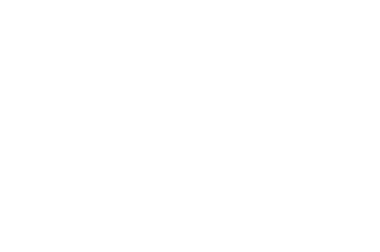

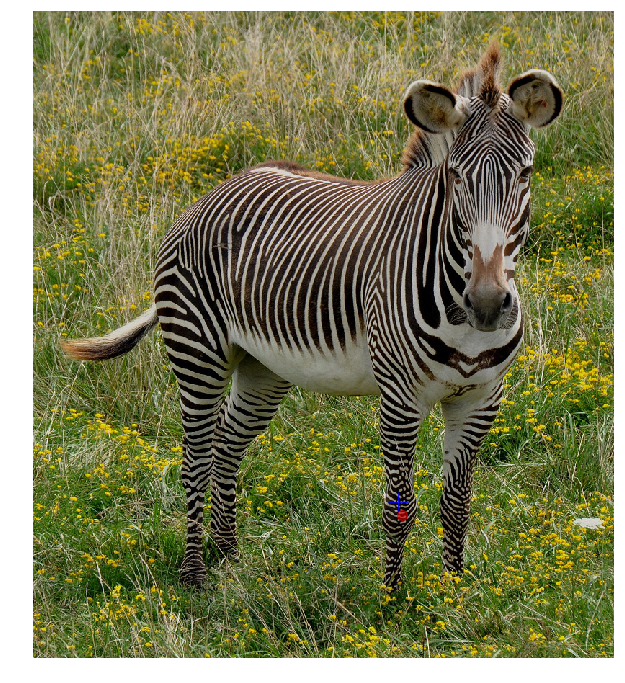

In [16]:
imagename =  'single_images_00/frame015.png' #'video_09/frame0001.png'  #single_images_00/frame016.png	

imindex = np.where(
            np.array(DataCombined.index.values) == imagename)[0]

image = io.imread('/is/ps2/calvarez2/DeepLabCut/pose-tensorflow/models/UnaugmentedDataSet_standingMay03/data-standing/' + imagename)

plt.axis('off')

bp = list(set(DataCombined.columns.get_level_values(1)))[0]

print imagename +' ' + str(DataCombined[scorer_machine][bp]['likelihood'].values[imindex]) #+ '\n'

h, w, nc = np.shape(image)
plt.figure(
    frameon=False, figsize=(w * 1. / 100 * scale, h * 1. / 100 * scale))
plt.subplots_adjust(
    left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.imshow(image, 'bone')

plt.plot(   DataCombined[scorer][bp]['x'].values[imindex],
            DataCombined[scorer][bp]['y'].values[imindex],
            Labels[1],
            color=Colorscheme[3],
            alpha=.8,
            ms=msize)

plt.plot(   
        DataCombined[scorer_machine][bp]['x'].values[imindex],
        DataCombined[scorer_machine][bp]['y'].values[imindex],
        Labels[0],
        color=Colorscheme[0],
        alpha=.5,
        ms=msize)

plt.xlim(0, w)
plt.ylim(0, h)
plt.axis('off')
plt.subplots_adjust(
    left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.gca().invert_yaxis()



#directory = 'result_images/result_images_May04' + '/' + imagename.split('/')[0]

#plt.savefig( directory + '_' + imagename.split('/')[1])

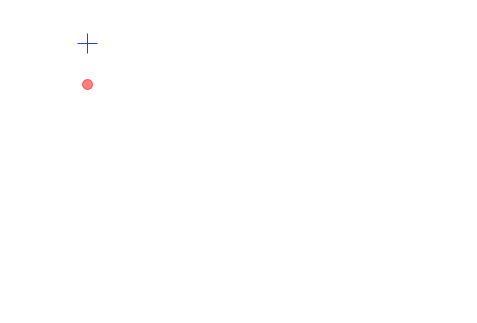

In [17]:

plt.plot(   100,
            100,
            Labels[1],
            color=Colorscheme[3],
            alpha=.8,
            ms=msize)

plt.plot(   
        100,
       230,
        Labels[0],
        color=Colorscheme[0],
        alpha=.5,
        ms=msize)

plt.xlim(0, w)
plt.ylim(0, h)
plt.axis('off')
plt.subplots_adjust(
    left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.gca().invert_yaxis()


# #-----------------Key points guide-------------------------------

In [18]:
x = np.asarray([0.22, 0.28, 0.22, 0.42, 0.37, 0.42, 0.44, 0.42, 0.46, 0.54, 0.53, 0.50, 0.79, 0.90, 0.71, 0.76, 0.72, 0.77, 0.82, 0.81, 0.26, 0.37, 0.20])
y = np.asarray([0.18, 0.20, 0.35, 0.20, 0.40, 0.56, 0.67, 0.80, 0.40, 0.57, 0.70, 0.82, 0.12, 0.43, 0.42, 0.50, 0.64, 0.42, 0.51, 0.67, 0.10, 0.14, 0.26 ])


In [19]:
direc =  '/is/ps2/calvarez2/zebra_project/original Silvia/'

In [20]:
data = pd.read_csv(direc + 'zebra_points.csv')

x = data.X.values
y = data.Y.values

<function matplotlib.pyplot.imshow>

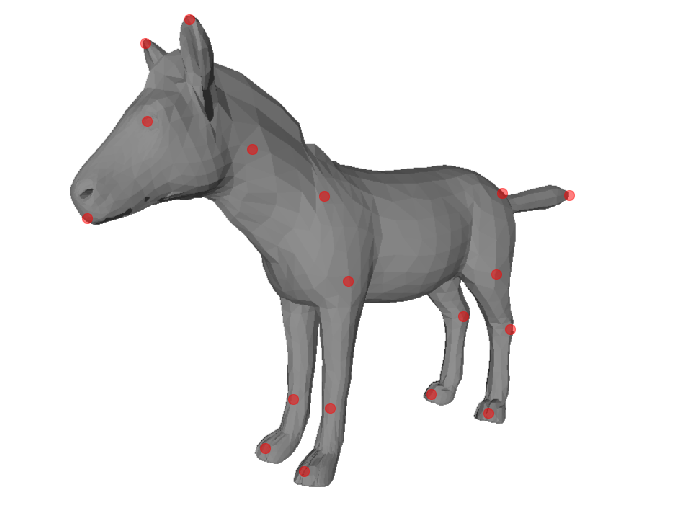

In [21]:
imagename =  'zebra1.png'# 'lionnew.png'


image = io.imread( direc + imagename)


h, w, nc = np.shape(image)

plt.figure(
    frameon=False, figsize=(w * 1. / 100 * scale, h * 1. / 100 * scale))
plt.subplots_adjust(
    left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.imshow(image, 'bone')

plt.plot(x,y, 
             Labels[0],
            color=Colorscheme[0],
            alpha=.5,
            ms=msize)

plt.axis('off')
plt.imshow

